## Problem 1

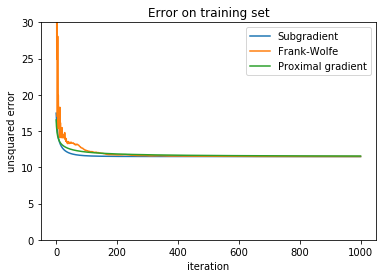

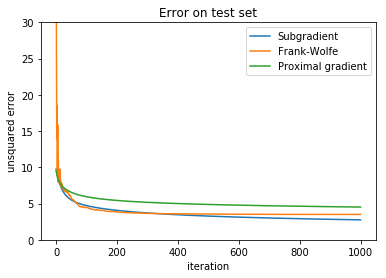

In [391]:
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
from __future__ import division
from time import *

def proximal_l1norm(x,t):
    # return the proximal function of t*||x||_1
    return (x>t)*(x-t)+(x<-t)*(x+t)

def proximal_gradient(x, A, b, t, lam, c=2e-4):
    grad = np.matmul(A.transpose(),np.dot(A,x)-b)
    eta=c/np.sqrt(t+1)
    x = proximal_l1norm(x-eta*grad, lam*eta)
    return x

def frank_wolfe(x, A, b, t, gam, c=1e-4):
    grad=np.dot(A.T,np.dot(A,x)-b)
    idx=np.argmax(np.abs(grad))
    s=np.zeros(A.shape[1])
    s[idx]=-gam * np.sign(grad[idx])
    eta=2/(t+2)    
    x=x+eta*(s-x)
    return x


def subgradient(x, A, b, t, lam, c=1e-4):
    grad=np.dot(A.T,np.dot(A,x)-b)+lam*np.sign(x)
    x = x - c*grad
    #print(grad[1:10])
    #print(x[1:10])
    return x


def descent(update, A, b, reg, T=int(1e3), c=1e-4):
    x = np.zeros(A.shape[1])
    error = []
    l1 = []
    loss = []
    elapsed_time = []
    start=time()
    y = x
    for t in range(T):
        x = update(x, A, b, t, reg, c)
        y = y + x
        end=time()
        if (t % 1 == 0) or (t == T - 1):
            error.append(la.norm(np.dot(A, x) - b))
            l1.append(np.sum(abs(x)))
            loss.append(0.5*(la.norm(np.dot(A, x) - b))**2+reg*np.sum(abs(x)))
            elapsed_time.append(end-start)
            #assert not np.isnan(error[-1])
    return x, error, l1, elapsed_time, loss


def main(T=int(1e4)):
    A_train = np.load("A_train.npy")
    b_train = np.load("b_train.npy")
    A_test = np.load("A_test.npy")
    b_test = np.load("b_test.npy")
    R, lam=5., 1e-4

    x_sg_train, error_sg_train, l1_sg_train, t_sg_train, loss_sg_train = descent(subgradient, A_train, b_train, reg=lam, T=T, c=1e-4)
    x_fw_train, error_fw_train, l1_fw_train, t_fw_train, loss_fw_train = descent(frank_wolfe, A_train, b_train, reg=R, T=T, c=1e-4)
    x_pg_train, error_pg_train, l1_pg_train, t_pg_train, loss_pg_train = descent(proximal_gradient, A_train, b_train, reg=lam, T=T, c=2e-4)
    
    x_sg_test, error_sg_test, l1_sg_test, t_sg_test, loss_sg_test = descent(subgradient, A_test, b_test, reg=lam, T=T, c=1e-4)
    x_fw_test, error_fw_test, l1_fw_test, t_fw_test, loss_fw_test = descent(frank_wolfe, A_test, b_test, reg=R, T=T, c=1e-4)
    x_pg_test, error_pg_test, l1_pg_test, t_pg_test, loss_pg_test = descent(proximal_gradient, A_test, b_test, reg=lam, T=T, c=2e-4)
    
    %matplotlib inline
    
    # x-axis is iteration
    fig=plt.figure()
    plt.plot(error_sg_train[:1000], label='Subgradient')
    plt.plot(error_fw_train[:1000], label='Frank-Wolfe')
    plt.plot(error_pg_train[:1000], label='Proximal gradient')
    plt.title('Error on training set')
    plt.xlabel('iteration')
    plt.ylabel('unsquared error')
    plt.ylim(0,30)
    plt.legend()
#     plt.savefig('error-train.eps')
    plt.show()
    

    # x-axis is iteration
    fig=plt.figure()
    plt.plot(error_sg_test[:1000], label='Subgradient')
    plt.plot(error_fw_test[:1000], label='Frank-Wolfe')
    plt.plot(error_pg_test[:1000], label='Proximal gradient')
    plt.title('Error on test set')
    plt.xlabel('iteration')
    plt.ylabel('unsquared error')
    plt.ylim(0,30)
    plt.legend()
#     plt.savefig('error-iter-1e3.eps')
    plt.show()   


if __name__ == "__main__":
    main()


## Problem 2

In [392]:
def descent_fista(A, b, reg, beta, T):
    x = np.zeros(A.shape[1])
    error = []
    l1 = []
    loss = []
    elapsed_time = []
    start=time()
    y = x
    lam=0.
    for t in range(T):
        grad = np.matmul(A.transpose(),np.dot(A,y)-b)
        x_new=proximal_l1norm(y-1.0/beta*grad,1.0/beta)
        lam_new=(1.0+np.sqrt(1.0+4.0*lam*lam))/2.0
        y = x_new +(lam-1)/lam_new*(x_new-x)
        x = x_new
        lam = lam_new
        end=time()
        if (t % 1 == 0) or (t == T - 1):
            error.append(la.norm(np.dot(A, x) - b))
            l1.append(np.sum(abs(x)))
            loss.append(0.5*(la.norm(np.dot(A, x) - b))**2+reg*np.sum(abs(x)))
            elapsed_time.append(end-start)
            assert not np.isnan(error[-1])
    return x, error, l1, elapsed_time, loss

In [393]:
np.random.seed(1)

def p2(T=int(1e3)):
    A=np.random.uniform(0,1,size=(3000,1500))
    print(A.shape)
    b=np.random.uniform(0,1,size=(3000,))
    print(b.shape)
    eigen,vec =la.eig(A.transpose().dot(A))
    beta = np.amax(eigen)
    print(beta)
    x_sg, error_sg, l1_sg, t_sg, loss_sg = descent(subgradient, A, b, reg=1, T=T, c=1.0/beta)
    x_ista, error_ista, l1_ista, t_ista, loss_ista = descent(proximal_gradient, A, b, reg=1, T=T, c=1.0/beta)
    x_fista, error_fista, l1_fista, t_fista, loss_fista = descent_fista( A, b, reg=1, beta=beta, T=T)
    
    # x-axis is iteration
    fig=plt.figure()
    plt.plot(loss_sg, label='Subgradient')
    plt.plot(loss_ista, label='ISTA')
    plt.plot(loss_fista, label='FISTA')
    plt.title('f(x)')
    plt.xlabel('iteration')
    plt.ylabel('f(x)')
#%plt.ylim(8,10)
    plt.legend()
#     plt.savefig('error-train.eps')
    plt.show()

(3000, 1500)
(3000,)
1125271.8959892606


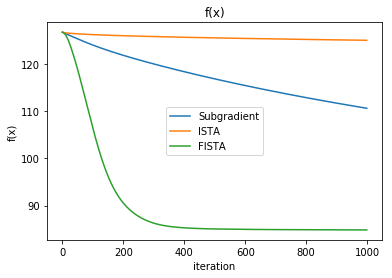

In [394]:
p2()

## Problem 3

In [399]:
def grad_logistic(x, A, b):
    denom =np.sum(np.exp(A.dot(x)+b))
    grad =np.exp(A.dot(x)+b).T.dot(A)/denom
    #print(grad)
    return grad
def sg_logistic(x, A, b, beta):    
    grad=grad_logistic(x, A, b)
    x = x - 1/beta*grad
    return x

def descent_sg_logistic(A, b, beta, T):
    x = np.zeros(A.shape[1])
    loss = []
    elapsed_time = []
    start=time()
    for t in range(T):
        x = sg_logistic(x, A, b, beta)
        end = time()
        if (t % 1 == 0) or (t == T - 1):
            loss.append(np.log(np.sum(np.exp(A.dot(x)+b))))
            elapsed_time.append(end-start)
    return x, elapsed_time, loss


def descent_agd(A, b, beta, T):
    x = np.zeros(A.shape[1])
    loss = []
    elapsed_time = []
    start=time()
    x_old = x.copy()
    lam=0.
    for t in range(T):
        lam_t=lam
        lam=(1.0+np.sqrt(1.0+4.0*lam_t*lam_t))/2.0
        gamma=(lam_t-1.0)/lam
        d_t=gamma*(x-x_old)
        grad = grad_logistic(x+d_t, A, b)
        x_old=x
        x = x+d_t-1./beta*grad
        end=time()
        if (t % 1 == 0) or (t == T - 1):
            loss.append(np.log(np.sum(np.exp(A.dot(x)+b))))
            elapsed_time.append(end-start)
    return x, elapsed_time, loss

def p3(T=int(1e3)):
    A=np.random.uniform(0,1,size=(3000,1500))
    b=np.random.uniform(0,1,size=(3000,))
    eigen =la.eigvals(A.transpose().dot(A))
    beta = np.amax(eigen)
    print(beta)
    x_sg, t_sg, loss_sg = descent_sg_logistic(A, b, beta=beta, T=T)
    x_agd, t_agd, loss_agd = descent_agd(A, b, beta=beta, T=T)
    
    # x-axis is iteration
    fig=plt.figure()
    plt.plot(loss_sg, label='Subgradient')
    plt.plot(loss_agd, label='Accelerated GD')
    plt.title('f(x)')
    plt.xlabel('iteration')
    plt.ylabel('f(x)')
    # plt.ylim(7,9)
    plt.legend()
#     plt.savefig('error-train.eps')
    plt.show()

1126026.3389785916


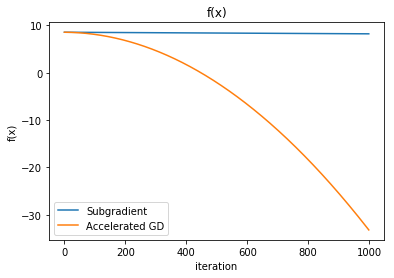

In [400]:
p3()

## Problem 4

In [307]:
import pandas as pd
X_train = pd.read_csv('X_train.csv',sep=',', header = None)
X_test = pd.read_csv('X_test.csv',sep=',', header = None)
y_train = pd.read_csv('y_train.csv',sep=',', header = None)
y_test = pd.read_csv('y_test.csv',sep=',', header = None)


In [401]:
X_train_encode = np.array(X_train) # 12564x2001
#y_train_encode = np.repeat(np.eye(20)[np.array(y_train).reshape(-1)],  2001, axis =1)
#X_train_encode = np.repeat(X_train, 20, axis =1)
y_train_encode = np.eye(20)[np.array(y_train).reshape(-1)] # 12564*20
X_test_encode = np.array(X_test) 
y_test_encode = np.eye(20)[np.array(y_test).reshape(-1)]
beta =np.zeros([2001,20])

In [315]:
beta.shape


(2001, 20)

$$
\frac{\partial f}{\partial \beta_j}=\frac{1}{N}\sum_{i=1}^N x_iy_{ij}+\frac{-x_iexp(-\beta_j^Tx_i)}{\sum_{j=1}^Cexp(-\beta_j^Tx_i)}+2\mu\beta_j
$$

In [429]:
def grad_logistic_l1( X, y, beta, mu, N):
    grad= np.zeros([2001,20])
    for i in range(20):
        grad[:,i]=1.0/N*np.sum(X*y[:,i].reshape([N,1])-X*np.exp(X.dot(beta[:,i].reshape([2001,1])))/np.sum(np.exp(-X.dot(beta)), axis =1).reshape([N,1]), axis =0)+mu*beta[:,i]
    #grad.reshape([2001*20,1])
    return grad
        

In [430]:
def loss_function(X,y,beta, mu):
    N=X.shape[0]
    tmp=0
    for i in range(20):
        tmp+= (X*y[:,i].reshape([N,1])).dot(beta[:,i])
    loss =1.0/N*np.sum(tmp+np.log(np.sum(np.exp(-X.dot(beta)), axis =1)), axis =0)+mu*(la.norm(beta)**2)
    return loss

In [432]:
def gradient_descent_logistic(X, y, X1, y1, mu, eta, T):
    beta = np.zeros([2001,20])
    f_value = []
    loss_test=[]
    elapsed_time = []
    start=time()
    N = X.shape[0]
    for t in range(T):
        grad=grad_logistic_l1(X, y, beta, mu, N)
        beta = beta- eta*grad
        end = time()
        if (t % 1 == 0) or (t == T - 1):
            f_value.append(loss_function(X,y,beta,mu))
            loss_test.append(loss_function(X1,y1,beta,0))
            elapsed_time.append(end-start)
    return beta, elapsed_time, f_value,loss_test

def accelerated_gd_logistic(X, y, X1, y1, mu, eta, T):
    beta = np.zeros([2001,20])
    f_value = []
    loss_test=[]
    elapsed_time = []
    start=time()
    N = X.shape[0]
    lam=0.
    beta_old=beta.copy()
    for t in range(T):
        lam_t=lam
        lam=(1.0+np.sqrt(1.0+4.0*lam_t*lam_t))/2.0
        gamma=(lam_t-1.0)/lam
        d_t=gamma*(beta-beta_old)
        grad=grad_logistic_l1(X, y, beta+d_t, mu, N)
        beta_old=beta
        beta=beta+d_t-eta*grad
        end = time()
        if (t % 1 == 0) or (t == T - 1):
            f_value.append(loss_function(X,y,beta,mu))
            loss_test.append(loss_function(X1,y1,beta,0))
            elapsed_time.append(end-start)
    return beta, elapsed_time, f_value,loss_test


## 4 (a) Choice of $\mu$

In [422]:
v_mu=[10, 1, 0.1, 1e-2, 1e-3,1e-4]
best_mu=0
v_loss_gd=[]
v_loss_agd=[]
least_test_loss=float('inf') 
for i in range(6):
    beta_gd, elapsed_time_gd, loss_gd,loss_gd_test= gradient_descent_logistic(X_train_encode, y_train_encode, X_test_encode, y_test_encode, mu=v_mu[i], eta=1e-4, T=10)
    beta_agd, elapsed_time_agd, loss_agd, loss_agd_test= accelerated_gd_logistic(X_train_encode, y_train_encode, X_test_encode, y_test_encode, mu=v_mu[i], eta=1e-4, T=10)
    v_loss_gd.append(loss_gd)
    v_loss_agd.append(loss_agd)
    test_loss = loss_function(X_test_encode,y_test_encode,beta_agd, mu=0)
    if test_loss <least_test_loss:
        best_mu=v_mu[i]

best_mu
        

0.0001

In [423]:
test_loss

2.9957297350656815

In the experiments, the best $\mu$ I found is 1e-4. However I was not able to get convergent results due to time limits. The test loss is 2.9957297350656815.

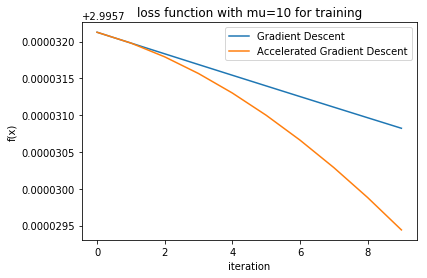

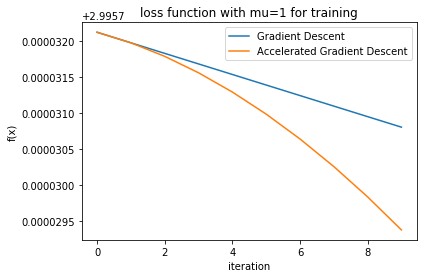

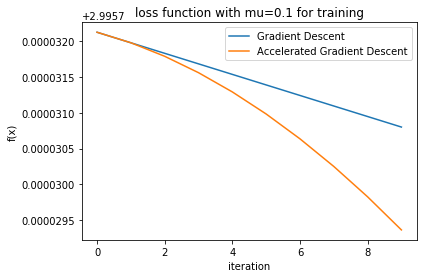

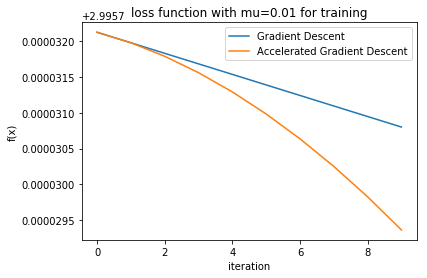

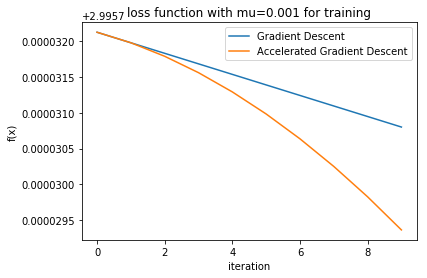

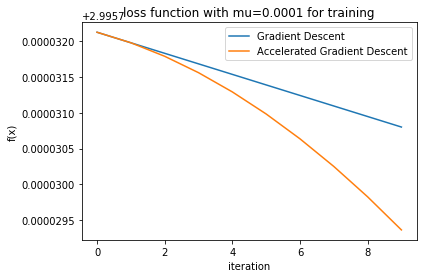

In [437]:
for i in range(6):
    fig=plt.figure()
    plt.plot(v_loss_gd[i], label='Gradient Descent')
    plt.plot(v_loss_agd[i], label='Accelerated Gradient Descent')
    #plt.plot(loss_agd, label='Accelerated GD')
    plt.title('loss function with mu='+str(v_mu[i])+' for training')
    plt.xlabel('iteration')
    plt.ylabel('f(x)')
    # plt.ylim(7,9)
    plt.legend()
#     plt.savefig('error-train.eps')
    plt.show()

In [436]:
beta_gd, elapsed_time_gd, loss_gd, loss_dg_test= gradient_descent_logistic(X_train_encode, y_train_encode, X_test_encode, y_test_encode, mu=best_mu, eta=1e-4, T=10)


In [435]:
beta_agd, elapsed_time_agd, loss_agd, loss_dg_test= accelerated_gd_logistic(X_train_encode, y_train_encode, X_test_encode, y_test_encode, mu=best_mu, eta=1e-4, T=10)

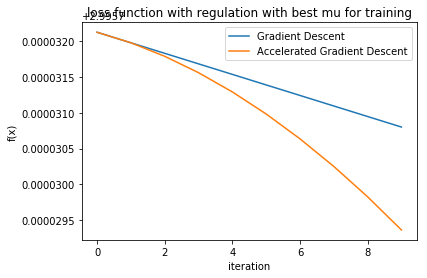

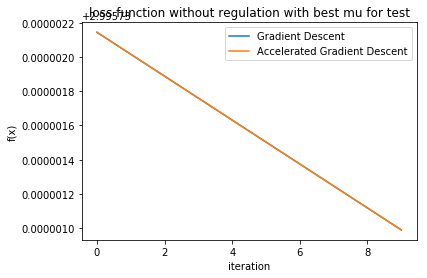

In [442]:

fig=plt.figure()
plt.plot(loss_gd, label='Gradient Descent')
plt.plot(loss_agd, label='Accelerated Gradient Descent')
#plt.plot(loss_agd, label='Accelerated GD')
plt.title('loss function with regulation with best mu for training')
plt.xlabel('iteration')
plt.ylabel('f(x)')
# plt.ylim(7,9)
plt.legend()
#     plt.savefig('error-train.eps')
plt.show()
    
    
fig=plt.figure()
plt.plot(loss_dg_test, label='Gradient Descent')
plt.plot(loss_dg_test, label='Accelerated Gradient Descent')
#plt.plot(loss_agd, label='Accelerated GD'u
plt.title('loss function without regulation with best mu for test')
plt.xlabel('iteration')
plt.ylabel('f(x)')
# plt.ylim(7,9)
plt.legend()
#     plt.savefig('error-train.eps')
plt.show()

## 4 (c) 

Gradient descent has $O(1/T)$ convergence rate, accelerated GD has $O(1/T^2)$ convergence rate. The rate does not depend on the choice of $\mu$.

## 4 (d)
The convergence rate is guaranteed because the loss function is strongly convex